In [75]:
# Loading Required Libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback, ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint
from keras import optimizers
!pip install opencv-python
import cv2
from google.colab.patches import cv2_imshow

In [3]:
# Connecting Drive to save models
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Creating class for emphasis
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [0]:
# Loading dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
X_Test = test_features
Y_Test = test_labels

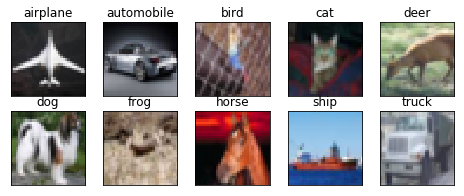

In [6]:
# Visualizing/Inspecting classes and images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Functions to Plot model History and Accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Cutout Function
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# Function to find the best LR
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim) if y_lim is not None else plt.ylim(min(derivatives) * 1.1, max(derivatives) * 1.1) 

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [0]:
# Preprocessing data for the model
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, (3, 3), border_mode='same', input_shape=(32, 32, 3))) #32x32
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3)) #30x30
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #15x15
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same')) #15x15
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3)) #13x13
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #6x6
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same')) #6x6
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3)) #4x4
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #2x2
model.add(Dropout(0.25))
model.add(Flatten()) #4x1
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0726 16:35:08.132841 140586565326720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
W0726 16:35:08.167006 140586565326720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 16:35:08.174722 140586565326720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
__________

In [24]:
# Running the model for 5 epochs to find the best LR
bs = 512
ep = 100
lr_finder = LRFinder(model)
lr_finder.find(train_features, train_labels, start_lr= 0.0001, end_lr= 1, batch_size=bs, epochs=5)

Epoch 1/5
50000/50000 [==============================] - 8s 154us/step - loss: 2.3058 - acc: 0.0981
Epoch 2/5
50000/50000 [==============================] - 7s 143us/step - loss: 2.3037 - acc: 0.1006
Epoch 3/5
50000/50000 [==============================] - 7s 144us/step - loss: 2.2966 - acc: 0.1145
Epoch 4/5
50000/50000 [==============================] - 7s 144us/step - loss: 2.2931 - acc: 0.1200
Epoch 5/5
50000/50000 [==============================] - 7s 142us/step - loss: 2.3051 - acc: 0.1008


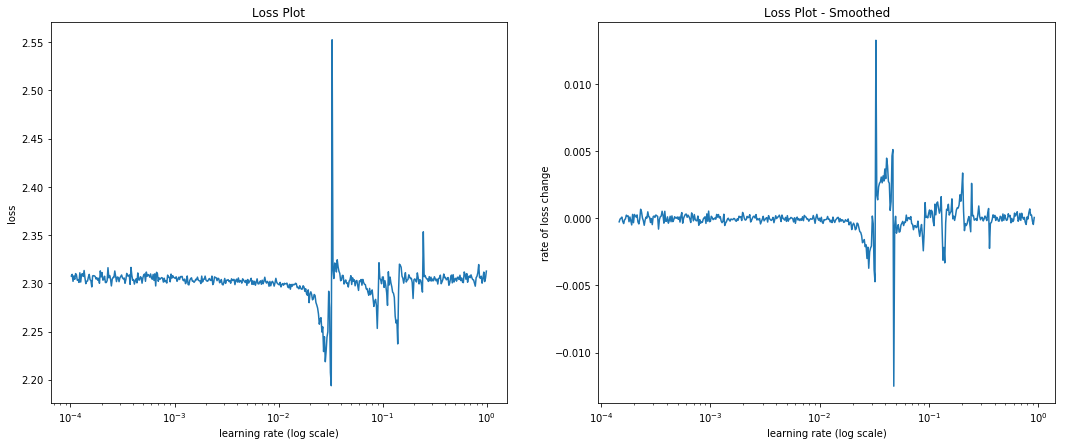

The LR found is 0.03272985 



In [26]:
# Plotting the Loss and LR
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Loss Plot')
im = lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Loss Plot - Smoothed')
im = lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=None)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

print(color.BOLD + color.RED + 'The LR found is %s \n' % (lr_finder.get_best_lr(sma=20, n_skip_beginning=20, n_skip_end=5)) + color.END)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=97, epochs=100)`


Model took 718.34 seconds to train


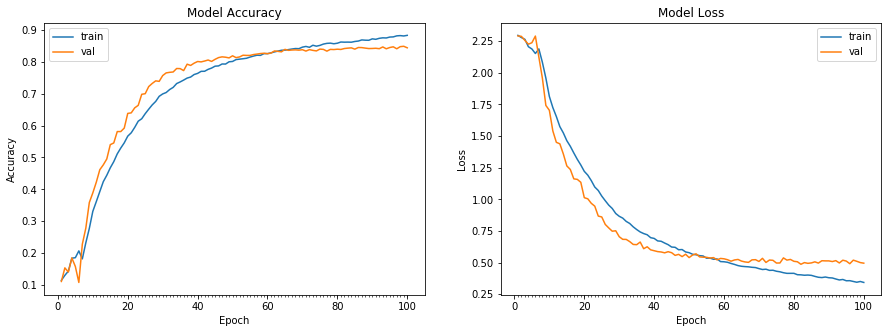

Accuracy on test data is: 84.38


In [27]:
# Training the model adding cutout via generator
K.set_value(model.optimizer.lr, lr_finder.get_best_lr(sma=20, n_skip_beginning=20, n_skip_end=5))

filepath="/content/gdrive/My Drive/EVA/P3/Try2/P11 - Best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0],
                                 nb_epoch = ep, 
                                 validation_data = (test_features, test_labels),
                                 verbose=0,
                                callbacks = [checkpoint])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [13]:
# Loading best model from the initial training
model.load_weights("/content/gdrive/My Drive/EVA/P3/Try2/P11 - Best.hdf5")

# Evaluating the model on the test data
score = model.evaluate(test_features, test_labels, verbose=0)
print("Highest Accuracy: %s" %(score[1]))

Highest Accuracy: 0.8485


In [0]:
# Indexing the incorrect predictions
incorrects = np.nonzero(model.predict_classes(test_features).reshape((-1,)) != Y_Test.reshape((-1,)))

In [0]:
# Creating sets of wrong presictions: Images,  Actual labels, and Predicted labels
wrong_x = X_Test[incorrects[0]]
wrong_y = Y_Test.reshape((-1,))[incorrects[0]]
wrong_p = model.predict_classes(test_features[incorrects[0]])

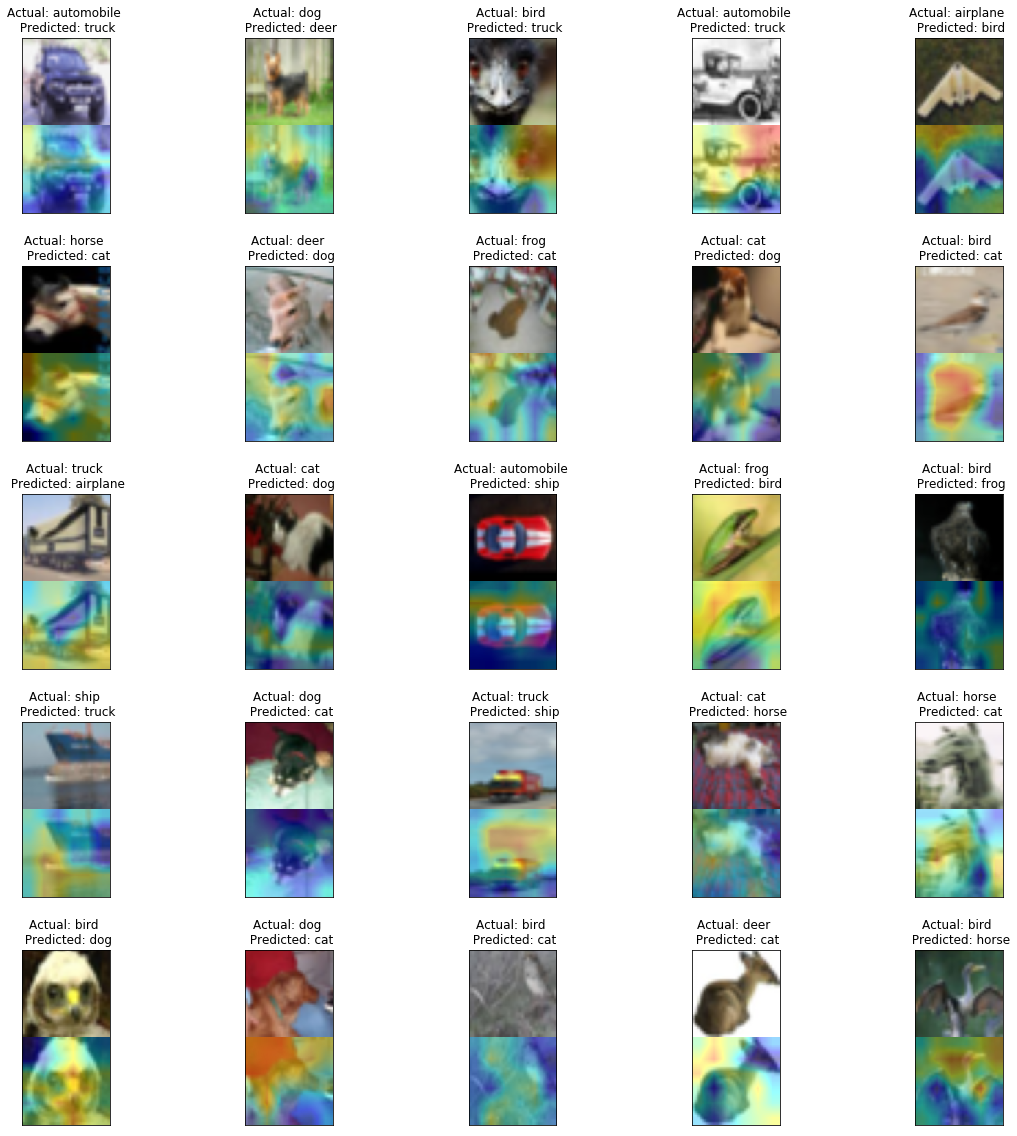

In [225]:
# Plotting wrongly clasified images using GradCam
n = 25

fig = plt.figure(figsize=(20,20))

for j in range(n):
  ax = fig.add_subplot(5, 5, j + 1, xticks = [], yticks = [])
  
  x = test_features[incorrects[0][j]]
  preds = model.predict(x.reshape(1,32,32,3))
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_5")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x.reshape(1,32,32,3)])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = X_Test[incorrects[0][j]]

  # img = cv2.imread(test_features[34])
  # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  img = cv2.resize(img, (128, 128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  
  horizontal_concat = np.concatenate((img, superimposed_img), axis=0)

  im = horizontal_concat
  ax.set_title('Actual: %s \n Predicted: %s' % (class_names[wrong_y[j]], class_names[class_idx]), color = "black")
  plt.subplots_adjust(hspace=0.3, wspace=0.0)
  plt.imshow(im)

plt.show()
